In [62]:
import os # Paths
import numpy as np # Arrays
import matplotlib.pyplot as plt #Plotting
from tqdm import tqdm  # Progress bar
# All of our torch stuff!
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
# Vision transformations and resnet
import torchvision.transforms as transforms
import torchvision.models as models
# visualization
import torchviz
import torchview
import time

In [2]:
from medmnist import PathMNIST

In [3]:
data_cache = './data'
batch_size = 128
num_epochs = 10
lr = 1e-4
num_workers = 6
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 

In [5]:
os.makedirs(data_cache, exist_ok=True)

In [6]:
# Beware, every moment has its own transformation normalization parameters! We're using ImageNet as our base
data_transform = transforms.Compose([
    transforms.Resize(256), # Resize because images are 28x28
    transforms.CenterCrop(224), # Crop
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # ImageNet norm
])

print("Downloading PathMNIST")
train_dataset = PathMNIST(split='train', transform=data_transform, download=True, root=data_cache)
val_dataset = PathMNIST(split='val', transform=data_transform, download=True, root=data_cache)
test_dataset = PathMNIST(split='test', transform=data_transform, download=True, root=data_cache)
print("Done.")


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 206M/206M [00:12<00:00, 15.9MB/s]


Done.


In [7]:
# Get dataset information
n_classes = len(train_dataset.info['label'])
print(f"Number of classes: {n_classes}")
print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Test samples: {len(test_dataset)}")


Number of classes: 9
Training samples: 89996
Validation samples: 10004
Test samples: 7180


In [9]:
train_loader = data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory='cuda')
val_loader = data.DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory='cuda')
test_loader = data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory='cuda')


In [10]:
# Load a small ImageNet for speed
model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)



Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /home/nikolas/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44.7M/44.7M [00:00<00:00, 114MB/s]


In [11]:
# Freeze all layers except the final classification layer
for param in model.parameters():
    param.requires_grad = False # This makes it so it does not keep a Gradient while running stuff, also makes it run easier

In [14]:
next(iter(train_loader))

[tensor([[[[ 1.3242,  1.3070,  1.2899,  ...,  1.0159,  1.0844,  1.1529],
           [ 1.2214,  1.2043,  1.1872,  ...,  0.9817,  1.0502,  1.1187],
           [ 1.1187,  1.1015,  1.0844,  ...,  0.9646,  1.0331,  1.1015],
           ...,
           [ 1.1187,  1.1187,  1.1529,  ...,  0.9474,  0.9988,  1.0673],
           [ 1.1700,  1.1700,  1.1872,  ...,  0.9646,  1.0159,  1.0844],
           [ 1.2214,  1.2214,  1.2214,  ...,  0.9817,  1.0331,  1.0844]],
 
          [[ 0.9580,  0.9405,  0.9055,  ...,  0.5728,  0.6604,  0.7654],
           [ 0.8004,  0.7829,  0.7479,  ...,  0.5378,  0.6254,  0.7304],
           [ 0.6254,  0.6254,  0.5903,  ...,  0.5028,  0.5903,  0.6779],
           ...,
           [ 0.6254,  0.6604,  0.6779,  ...,  0.3277,  0.3978,  0.4853],
           [ 0.7129,  0.7304,  0.7304,  ...,  0.3452,  0.4328,  0.5028],
           [ 0.8004,  0.8004,  0.7829,  ...,  0.3803,  0.4503,  0.5378]],
 
          [[ 1.6988,  1.6814,  1.6640,  ...,  1.4200,  1.4897,  1.5594],
           [ 

In [27]:
t = next(iter(train_loader))[0]
y = model(t)

In [30]:
torchviz.make_dot(y, params=dict(model.named_parameters()))

ValueError: dictionary update sequence element #0 has length 64; 2 is required

In [32]:
t.shape

torch.Size([128, 3, 224, 224])

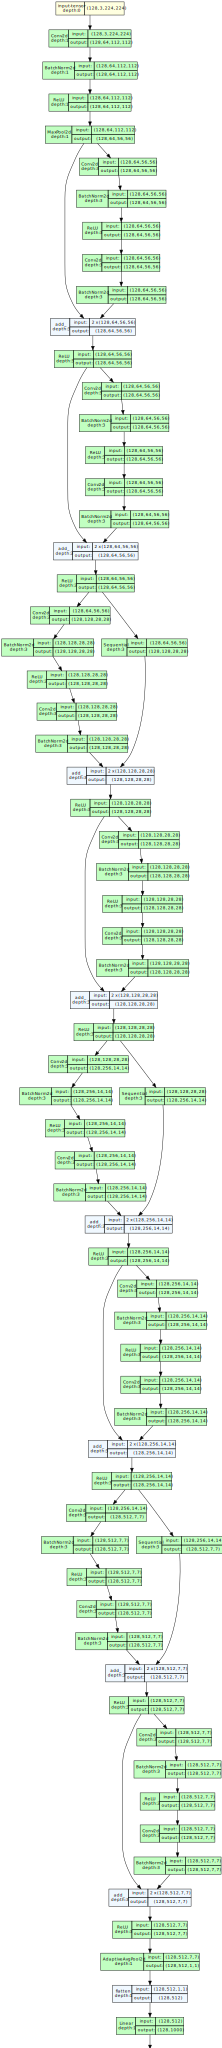

In [34]:
from torchview import draw_graph


model_graph = draw_graph(model, input_size=((batch_size, 3,224,224)), device='meta')
model_graph.visual_graph

In [35]:
dict(model.named_parameters()).keys()

dict_keys(['conv1.weight', 'bn1.weight', 'bn1.bias', 'layer1.0.conv1.weight', 'layer1.0.bn1.weight', 'layer1.0.bn1.bias', 'layer1.0.conv2.weight', 'layer1.0.bn2.weight', 'layer1.0.bn2.bias', 'layer1.1.conv1.weight', 'layer1.1.bn1.weight', 'layer1.1.bn1.bias', 'layer1.1.conv2.weight', 'layer1.1.bn2.weight', 'layer1.1.bn2.bias', 'layer2.0.conv1.weight', 'layer2.0.bn1.weight', 'layer2.0.bn1.bias', 'layer2.0.conv2.weight', 'layer2.0.bn2.weight', 'layer2.0.bn2.bias', 'layer2.0.downsample.0.weight', 'layer2.0.downsample.1.weight', 'layer2.0.downsample.1.bias', 'layer2.1.conv1.weight', 'layer2.1.bn1.weight', 'layer2.1.bn1.bias', 'layer2.1.conv2.weight', 'layer2.1.bn2.weight', 'layer2.1.bn2.bias', 'layer3.0.conv1.weight', 'layer3.0.bn1.weight', 'layer3.0.bn1.bias', 'layer3.0.conv2.weight', 'layer3.0.bn2.weight', 'layer3.0.bn2.bias', 'layer3.0.downsample.0.weight', 'layer3.0.downsample.1.weight', 'layer3.0.downsample.1.bias', 'layer3.1.conv1.weight', 'layer3.1.bn1.weight', 'layer3.1.bn1.bias', 

In [36]:
num_ftrs = model.fc.in_features

In [37]:
print(num_ftrs)

512


In [58]:
model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

model.fc = nn.Linear(num_ftrs, n_classes)
model = model.to(device)

# Fully trainable
for param in model.parameters():
    param.requires_grad = True 

In [59]:
len(train_loader)

704

In [60]:
num_epochs=5

In [63]:


criterion = nn.CrossEntropyLoss() # Suitable for multi-class classification


#optimizer = optim.AdamW(model.fc.parameters(), lr=lr,weight_decay=0.01)
optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=lr,weight_decay=0.01) #To run all parameters with grads

top_val_acc = 0.0 # Keep track of the best validation accuracy

start_time = time.perf_counter()
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0
    batch_counter = 0
    for inputs, labels in train_loader:
        batch_counter = batch_counter + 1
        if batch_counter % 50 == 0:
            print('Completed batch:', batch_counter)
        labels = labels.squeeze().long() # Fix shape

        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass
        loss.backward()
        optimizer.step()

        # Stats
        train_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

    train_epoch_loss = train_loss / len(train_loader.dataset)
    train_epoch_acc = train_correct / train_total
    print(f"\nEpoch {epoch+1} Train Loss: {train_epoch_loss:.4f} Acc: {train_epoch_acc:.4f}")
    # Val run
    model.eval() 
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad(), torch.inference_mode():
        for inputs, labels in val_loader:
            labels = labels.squeeze().long()
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()


    val_epoch_loss = val_loss / len(val_loader.dataset)
    val_epoch_acc = val_correct / val_total
    print(f"Epoch {epoch+1} Val Loss: {val_epoch_loss:.4f} Acc: {val_epoch_acc:.4f}")


    model.eval() # Set model to evaluation mode

    test_correct = 0
    test_total = 0
    all_preds = []
    all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        labels = labels.squeeze().long()
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)

        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())



test_acc = test_correct / test_total
print(f"\nTest Accuracy: {test_acc:.4f}")

end_time = time.perf_counter()

print(end_time - start_time)

Completed batch: 50
Completed batch: 100
Completed batch: 150
Completed batch: 200
Completed batch: 250
Completed batch: 300
Completed batch: 350
Completed batch: 400
Completed batch: 450
Completed batch: 500
Completed batch: 550
Completed batch: 600
Completed batch: 650
Completed batch: 700

Epoch 1 Train Loss: 0.1655 Acc: 0.9449
Epoch 1 Val Loss: 0.0873 Acc: 0.9711
Completed batch: 50
Completed batch: 100
Completed batch: 150
Completed batch: 200
Completed batch: 250
Completed batch: 300
Completed batch: 350
Completed batch: 400
Completed batch: 450
Completed batch: 500
Completed batch: 550
Completed batch: 600
Completed batch: 650
Completed batch: 700

Epoch 2 Train Loss: 0.0491 Acc: 0.9834


Exception in thread Thread-44:
Traceback (most recent call last):
  File "/home/nikolas/miniconda3/lib/python3.9/threading.py", line 980, in _bootstrap_inner
    self.run()
  File "/home/nikolas/miniconda3/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 761, in run_closure
    _threading_Thread_run(self)
  File "/home/nikolas/miniconda3/lib/python3.9/threading.py", line 917, in run
    self._target(*self._args, **self._kwargs)
  File "/home/nikolas/miniconda3/lib/python3.9/site-packages/torch/utils/data/_utils/pin_memory.py", line 59, in _pin_memory_loop
    do_one_step()
  File "/home/nikolas/miniconda3/lib/python3.9/site-packages/torch/utils/data/_utils/pin_memory.py", line 35, in do_one_step
    r = in_queue.get(timeout=MP_STATUS_CHECK_INTERVAL)
  File "/home/nikolas/miniconda3/lib/python3.9/multiprocessing/queues.py", line 122, in get
    return _ForkingPickler.loads(res)
  File "/home/nikolas/miniconda3/lib/python3.9/site-packages/torch/multiprocessing/reductions.py", lin

KeyboardInterrupt: 

In [66]:
with torch.no_grad():
    for inputs, labels in test_loader:
        labels = labels.squeeze().long()
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)

        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())



test_acc = test_correct / test_total
print(f"\nTest Accuracy: {test_acc:.4f}")

end_time = time.perf_counter()

print(end_time - start_time)


Test Accuracy: 0.8863
167.8910861397162


In [67]:
# Load a small ImageNet for speed
model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

# Freeze all layers except the final classification layer
for param in model.parameters():
    param.requires_grad = False 
    
model.fc = nn.Linear(num_ftrs, n_classes)
model = model.to(device)

In [68]:


criterion = nn.CrossEntropyLoss() # Suitable for multi-class classification


optimizer = optim.AdamW(model.fc.parameters(), lr=lr,weight_decay=0.01)
# optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr) #To run all parameters with grads

start_time = time.perf_counter()

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0
    batch_counter = 0
    for inputs, labels in train_loader:
        batch_counter = batch_counter + 1
        if batch_counter % 20 == 0:
            print('Completed batch:', batch_counter)
        labels = labels.squeeze().long() # Fix shape

        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass
        loss.backward()
        optimizer.step()

        # Stats
        train_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

    train_epoch_loss = train_loss / len(train_loader.dataset)
    train_epoch_acc = train_correct / train_total
    print(f"\nEpoch {epoch+1} Train Loss: {train_epoch_loss:.4f} Acc: {train_epoch_acc:.4f}")
    # Val run
    model.eval() 
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad(), torch.inference_mode():
        for inputs, labels in val_loader:
            labels = labels.squeeze().long()
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()


    val_epoch_loss = val_loss / len(val_loader.dataset)
    val_epoch_acc = val_correct / val_total
    print(f"Epoch {epoch+1} Val Loss: {val_epoch_loss:.4f} Acc: {val_epoch_acc:.4f}")


model.eval() # Set model to evaluation mode

test_correct = 0
test_total = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        labels = labels.squeeze().long()
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)

        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())



test_acc = test_correct / test_total
print(f"\nTest Accuracy: {test_acc:.4f}")

end_time = time.perf_counter()


print(end_time - start_time)

Completed batch: 20
Completed batch: 40
Completed batch: 60
Completed batch: 80
Completed batch: 100
Completed batch: 120
Completed batch: 140
Completed batch: 160
Completed batch: 180
Completed batch: 200
Completed batch: 220
Completed batch: 240
Completed batch: 260
Completed batch: 280
Completed batch: 300
Completed batch: 320
Completed batch: 340
Completed batch: 360
Completed batch: 380
Completed batch: 400
Completed batch: 420
Completed batch: 440
Completed batch: 460
Completed batch: 480
Completed batch: 500
Completed batch: 520
Completed batch: 540
Completed batch: 560
Completed batch: 580
Completed batch: 600
Completed batch: 620
Completed batch: 640
Completed batch: 660
Completed batch: 680
Completed batch: 700

Epoch 1 Train Loss: 1.2115 Acc: 0.6626
Epoch 1 Val Loss: 0.7632 Acc: 0.7912
Completed batch: 20
Completed batch: 40
Completed batch: 60
Completed batch: 80
Completed batch: 100
Completed batch: 120
Completed batch: 140
Completed batch: 160
Completed batch: 180
Complet

KeyboardInterrupt: 

In [69]:
with torch.no_grad():
    for inputs, labels in test_loader:
        labels = labels.squeeze().long()
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)

        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())



test_acc = test_correct / test_total
print(f"\nTest Accuracy: {test_acc:.4f}")


Test Accuracy: 0.8473


In [70]:
import time

In [75]:
model = models.resnet18(weights=None) # weights=None means random initialization
# Replace the final layer
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, n_classes)

# Fully trainable
for param in model.parameters():
    param.requires_grad = True 
    
model = model.to(device)

In [76]:


criterion = nn.CrossEntropyLoss() # Suitable for multi-class classification


optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=lr,weight_decay=0.01) #To run all parameters with grads

start_time = time.perf_counter()
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0
    batch_counter = 0
    for inputs, labels in train_loader:
        batch_counter = batch_counter + 1
        if batch_counter % 50 == 0:
            print('Completed batch:', batch_counter)
        labels = labels.squeeze().long() # Fix shape

        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass
        loss.backward()
        optimizer.step()

        # Stats
        train_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

    train_epoch_loss = train_loss / len(train_loader.dataset)
    train_epoch_acc = train_correct / train_total
    print(f"\nEpoch {epoch+1} Train Loss: {train_epoch_loss:.4f} Acc: {train_epoch_acc:.4f}")
    # Val run
    model.eval() 
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad(), torch.inference_mode():
        for inputs, labels in val_loader:
            labels = labels.squeeze().long()
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()


    val_epoch_loss = val_loss / len(val_loader.dataset)
    val_epoch_acc = val_correct / val_total
    print(f"Epoch {epoch+1} Val Loss: {val_epoch_loss:.4f} Acc: {val_epoch_acc:.4f}")


model.eval() # Set model to evaluation mode

test_correct = 0
test_total = 0
all_preds = []
all_labels = []

Completed batch: 50
Completed batch: 100
Completed batch: 150
Completed batch: 200
Completed batch: 250
Completed batch: 300
Completed batch: 350
Completed batch: 400
Completed batch: 450
Completed batch: 500
Completed batch: 550
Completed batch: 600
Completed batch: 650
Completed batch: 700

Epoch 1 Train Loss: 0.4533 Acc: 0.8355
Epoch 1 Val Loss: 0.3362 Acc: 0.8849
Completed batch: 50
Completed batch: 100
Completed batch: 150
Completed batch: 200
Completed batch: 250
Completed batch: 300
Completed batch: 350
Completed batch: 400
Completed batch: 450
Completed batch: 500
Completed batch: 550
Completed batch: 600
Completed batch: 650
Completed batch: 700

Epoch 2 Train Loss: 0.2360 Acc: 0.9167
Epoch 2 Val Loss: 1.3103 Acc: 0.7643
Completed batch: 50
Completed batch: 100
Completed batch: 150
Completed batch: 200
Completed batch: 250
Completed batch: 300
Completed batch: 350
Completed batch: 400
Completed batch: 450
Completed batch: 500
Completed batch: 550
Completed batch: 600
Completed

NameError: name 'test_pbar' is not defined

In [77]:

with torch.no_grad():
    for inputs, labels in test_loader:
        labels = labels.squeeze().long()
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)

        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())



test_acc = test_correct / test_total
print(f"\nTest Accuracy: {test_acc:.4f}")

end_time = time.perf_counter()

print(end_time - start_time)


Test Accuracy: 0.6478
740.8635044628754
